In [1]:
# Init libraries
import warnings
import mne
import numpy as np
from sklearn.exceptions import ConvergenceWarning

np.random.seed(23)
mne.set_log_level(verbose='warning') #to avoid info at terminal
warnings.filterwarnings(action = "ignore", category = DeprecationWarning )
warnings.filterwarnings(action = "ignore", category = FutureWarning )
warnings.filterwarnings(action = "ignore", category = ConvergenceWarning )

In [2]:
# Project defaults
# The root dir
root_dir = "./ds003626"

# Sampling rate
fs = 256

# Select the useful par of each trial. Time in seconds
t_start = 1.5
t_end = 3.5

In [3]:
# Load dataset
from aux.pre_process import get_subjects_data_and_label, get_subjects_data_label_group

condition = "Inner"
data, labels, groups = get_subjects_data_label_group(root_dir, condition, t_start = t_start, t_end = t_end, fs = fs)
len(data), len(labels), len(groups)

(10, 10, 10)

In [4]:
data_array=np.vstack(data)
label_array=np.hstack(labels)
group_array=np.hstack(groups)

In [5]:
data_array.shape, label_array.shape, group_array.shape

((2236, 128, 512), (2236,), (2236,))

In [6]:
from scipy import integrate
# Define all the features
from scipy import stats
import antropy as ant

def mean(x):
    return np.mean(x, axis=-1)

def std(x):
    return np.std(x, axis=-1)

def ptp(x):
    return np.ptp(x, axis=-1)

def var(x):
    return np.var(x, axis=-1)

def minim(x):
    return np.min(x, axis=-1)

def maxim(x):
    return np.max(x, axis=-1)

def argminim(x):
    return np. argmin(x, axis=-1)

def argmaxim(x):
    return np.argmax(x,axis=-1)

def rms(x):
    return np.sqrt(np.mean(x**2, axis=-1))

def abs_diff_signal(x):
    return np.sum(np.abs(np.diff(x, axis=-1)), axis=-1)

def skewness(x):
    return stats.skew(x, axis=-1)

def kurtosis(x):
    return stats.kurtosis(x, axis=-1)

def f_minplusmax(x):
    return np.max(x, axis=-1) + np.min(x, axis=-1)

def f_maxminusmin(x):
    return np.max(x, axis=-1) - np.min(x, axis=-1)

def f_spec_entropy(x):
    return ant.spectral_entropy(x, fs, method="welch", normalize=True, axis=-1)

def f_integral(x):
    return integrate.simps(x, axis=-1)

def f_petrosian(x):
    return ant.petrosian_fd(x, axis=-1)

def f_katz(x):
    return ant.katz_fd(x, axis=-1)

def concatenate_features(x):
    # Uncomment the desired line to add the feature
    return np.concatenate((
        mean(x),
        std(x),
        ptp(x),
        var(x),
        minim(x),
        maxim(x),
        argminim(x),
        argmaxim(x),
        rms(x),
        abs_diff_signal(x),
        skewness(x),
        kurtosis(x),
        # f_minplusmax(x),
        # f_maxminusmin(x),
        # f_spec_entropy(x),
        # f_integral(x),
        # f_katz(x),
        # f_petrosian(x),
    ), axis=-1)

In [7]:
features=[]
for d in data_array:
    features.append(concatenate_features(d))
features_array=np.array(features)

In [8]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier

random_state = 42
splits = [0.10, 0.20, 0.30]

In [9]:
def run_cross_validation(classifier, k_fold, x_tr, y_tr, group):
    # Changed to use StratifiedKFold
    #k_fold = model_selection.StratifiedKFold(n_splits=5)
    #k_fold = model_selection.StratifiedKFold(n_splits=5)
    results = model_selection.cross_val_score(classifier, x_tr, y_tr, cv=k_fold, scoring='accuracy', groups=group)
    return results.mean()

In [10]:
from sklearn.svm import SVC
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel, SelectKBest, chi2
from sklearn import metrics, model_selection
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

# Run the experiment

# Prepare the data
X = features_array
y = label_array
#X = MinMaxScaler().fit_transform(X)
X = StandardScaler().fit_transform(X)

# Feature Selection - There are other parameters we could set for Feature Selection
print("Old shape: ", X.shape)

# Select one fs here
fs = LinearSVC(C=0.01, penalty="l2", dual=False).fit(X, y)
# fs = SVC(kernel="linear").fit(X, y)
# fs = ExtraTreesClassifier(n_estimators=50).fit(X, y)

model = SelectFromModel(fs, prefit=True)
X = model.transform(X)

# or use this one
# X = SelectKBest(chi2, k=100).fit_transform(X, y)

print("New shape: ", X.shape)

Old shape:  (2236, 1536)
New shape:  (2236, 681)


In [12]:
# We change the axis order to have # of channels at the end and not in the middle
#data_array = np.moveaxis(data_array,1,2)
#data_array.shape

In [16]:
from sklearn.model_selection import GroupKFold, StratifiedGroupKFold

inner_cv = StratifiedGroupKFold(n_splits=5)
outer_cv = StratifiedGroupKFold(n_splits=5)

In [17]:
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV

# Run Nested cross-validation

classifiers = [
    ["Random Forest", RandomForestClassifier(random_state=random_state), {'n_estimators': [200, 500], 'max_features': ['auto', 'sqrt', 'log2'], 'max_depth' : [4,5,6,7,8], 'criterion' :['gini', 'entropy']}],
    ["Neural Network", MLPClassifier(random_state=random_state), {'solver': ['lbfgs'], 'max_iter': [200, 1000,1100,1200,1300,1400,1500,1600,1700,1800,1900,2000 ], 'alpha': 10.0 ** -np.arange(1, 10), 'hidden_layer_sizes':np.arange(10, 15)}],
    ["Linear SVC", LinearSVC(random_state=random_state), {'C': [0.00001, 0.0001, 0.0005], 'dual': (True, False)}],
    ["SVC", SVC(random_state=random_state), [{"kernel": ["rbf"], "gamma": [1e-3, 1e-4], "C": [1, 10, 100, 1000]}, {"kernel": ["linear"], "C": [1, 10, 100, 1000]}, ]], # The third parameter here is an array
]

for test_size in splits:
    print("\nSplit: Train:{}% Test:{}%".format(100 - (test_size * 100), test_size * 100))

    # Stratify guarantees that the same proportion of the classes will be available in train and test
    x_train, x_test, y_train, y_test, g_train, g_test = train_test_split(X, y, group_array, test_size=test_size, stratify=y)

    for cls in classifiers:
        print('{}: {} '.format("Classifier", cls[0]))
        clf = GridSearchCV(estimator=cls[1], param_grid=cls[2], cv=inner_cv, n_jobs=-1)
        clf.fit(x_train, y_train, groups=g_train)
        print(f"The best parameters found are: {clf.best_params_}")
        print(f"The mean CV score of the best model is: {clf.best_score_:.3f}")

        print("Grid scores on development set:\n")
        means = clf.cv_results_["mean_test_score"]
        stds = clf.cv_results_["std_test_score"]
        for mean, std, params in zip(means, stds, clf.cv_results_["params"]):
            print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))

        print("\nDetailed classification report:\n")
        print("The model is trained on the full development set.")
        print("The scores are computed on the full evaluation set.\n")
        y_true, y_pred = y_test, clf.predict(x_test)
        print(classification_report(y_true, y_pred))
        print()


Split: Train:90.0% Test:10.0%
Classifier: Random Forest 
The best parameters found are: {'criterion': 'entropy', 'max_depth': 5, 'max_features': 'auto', 'n_estimators': 500}
The mean CV score of the best model is: 0.268
Grid scores on development set:

0.256 (+/-0.046) for {'criterion': 'gini', 'max_depth': 4, 'max_features': 'auto', 'n_estimators': 200}
0.256 (+/-0.047) for {'criterion': 'gini', 'max_depth': 4, 'max_features': 'auto', 'n_estimators': 500}
0.256 (+/-0.046) for {'criterion': 'gini', 'max_depth': 4, 'max_features': 'sqrt', 'n_estimators': 200}
0.256 (+/-0.047) for {'criterion': 'gini', 'max_depth': 4, 'max_features': 'sqrt', 'n_estimators': 500}
0.250 (+/-0.044) for {'criterion': 'gini', 'max_depth': 4, 'max_features': 'log2', 'n_estimators': 200}
0.265 (+/-0.015) for {'criterion': 'gini', 'max_depth': 4, 'max_features': 'log2', 'n_estimators': 500}
0.259 (+/-0.029) for {'criterion': 'gini', 'max_depth': 5, 'max_features': 'auto', 'n_estimators': 200}
0.253 (+/-0.015) f

/opt/anaconda3/envs/thesisMaster/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/opt/anaconda3/envs/thesisMaster/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/opt/anaconda3/envs/thesisMaster/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs

The best parameters found are: {'alpha': 0.001, 'hidden_layer_sizes': 13, 'max_iter': 1000, 'solver': 'lbfgs'}
The mean CV score of the best model is: 0.296
Grid scores on development set:

0.282 (+/-0.049) for {'alpha': 0.1, 'hidden_layer_sizes': 10, 'max_iter': 200, 'solver': 'lbfgs'}
0.280 (+/-0.040) for {'alpha': 0.1, 'hidden_layer_sizes': 10, 'max_iter': 1000, 'solver': 'lbfgs'}
0.280 (+/-0.040) for {'alpha': 0.1, 'hidden_layer_sizes': 10, 'max_iter': 1100, 'solver': 'lbfgs'}
0.280 (+/-0.040) for {'alpha': 0.1, 'hidden_layer_sizes': 10, 'max_iter': 1200, 'solver': 'lbfgs'}
0.280 (+/-0.040) for {'alpha': 0.1, 'hidden_layer_sizes': 10, 'max_iter': 1300, 'solver': 'lbfgs'}
0.280 (+/-0.040) for {'alpha': 0.1, 'hidden_layer_sizes': 10, 'max_iter': 1400, 'solver': 'lbfgs'}
0.280 (+/-0.040) for {'alpha': 0.1, 'hidden_layer_sizes': 10, 'max_iter': 1500, 'solver': 'lbfgs'}
0.280 (+/-0.040) for {'alpha': 0.1, 'hidden_layer_sizes': 10, 'max_iter': 1600, 'solver': 'lbfgs'}
0.280 (+/-0.040) fo

/opt/anaconda3/envs/thesisMaster/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/opt/anaconda3/envs/thesisMaster/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/opt/anaconda3/envs/thesisMaster/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs

The best parameters found are: {'alpha': 0.01, 'hidden_layer_sizes': 12, 'max_iter': 200, 'solver': 'lbfgs'}
The mean CV score of the best model is: 0.295
Grid scores on development set:

0.278 (+/-0.053) for {'alpha': 0.1, 'hidden_layer_sizes': 10, 'max_iter': 200, 'solver': 'lbfgs'}
0.278 (+/-0.033) for {'alpha': 0.1, 'hidden_layer_sizes': 10, 'max_iter': 1000, 'solver': 'lbfgs'}
0.278 (+/-0.033) for {'alpha': 0.1, 'hidden_layer_sizes': 10, 'max_iter': 1100, 'solver': 'lbfgs'}
0.278 (+/-0.033) for {'alpha': 0.1, 'hidden_layer_sizes': 10, 'max_iter': 1200, 'solver': 'lbfgs'}
0.278 (+/-0.033) for {'alpha': 0.1, 'hidden_layer_sizes': 10, 'max_iter': 1300, 'solver': 'lbfgs'}
0.278 (+/-0.033) for {'alpha': 0.1, 'hidden_layer_sizes': 10, 'max_iter': 1400, 'solver': 'lbfgs'}
0.278 (+/-0.033) for {'alpha': 0.1, 'hidden_layer_sizes': 10, 'max_iter': 1500, 'solver': 'lbfgs'}
0.278 (+/-0.033) for {'alpha': 0.1, 'hidden_layer_sizes': 10, 'max_iter': 1600, 'solver': 'lbfgs'}
0.278 (+/-0.033) for 

/opt/anaconda3/envs/thesisMaster/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/opt/anaconda3/envs/thesisMaster/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/opt/anaconda3/envs/thesisMaster/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs

The best parameters found are: {'alpha': 1e-05, 'hidden_layer_sizes': 11, 'max_iter': 200, 'solver': 'lbfgs'}
The mean CV score of the best model is: 0.296
Grid scores on development set:

0.272 (+/-0.046) for {'alpha': 0.1, 'hidden_layer_sizes': 10, 'max_iter': 200, 'solver': 'lbfgs'}
0.266 (+/-0.034) for {'alpha': 0.1, 'hidden_layer_sizes': 10, 'max_iter': 1000, 'solver': 'lbfgs'}
0.266 (+/-0.034) for {'alpha': 0.1, 'hidden_layer_sizes': 10, 'max_iter': 1100, 'solver': 'lbfgs'}
0.266 (+/-0.034) for {'alpha': 0.1, 'hidden_layer_sizes': 10, 'max_iter': 1200, 'solver': 'lbfgs'}
0.266 (+/-0.034) for {'alpha': 0.1, 'hidden_layer_sizes': 10, 'max_iter': 1300, 'solver': 'lbfgs'}
0.266 (+/-0.034) for {'alpha': 0.1, 'hidden_layer_sizes': 10, 'max_iter': 1400, 'solver': 'lbfgs'}
0.266 (+/-0.034) for {'alpha': 0.1, 'hidden_layer_sizes': 10, 'max_iter': 1500, 'solver': 'lbfgs'}
0.266 (+/-0.034) for {'alpha': 0.1, 'hidden_layer_sizes': 10, 'max_iter': 1600, 'solver': 'lbfgs'}
0.266 (+/-0.034) for

In [18]:
inner_cv = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=random_state)
outer_cv = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=random_state)

classifiers = [
    ["Random Forest", RandomForestClassifier(random_state=random_state), {'n_estimators': [200, 500], 'max_features': ['auto', 'sqrt', 'log2'], 'max_depth' : [4,5,6,7,8], 'criterion' :['gini', 'entropy']}],
    ["Neural Network", MLPClassifier(random_state=random_state), {'solver': ['lbfgs'], 'max_iter': [200, 1000,1100,1200,1300,1400,1500,1600,1700,1800,1900,2000 ], 'alpha': 10.0 ** -np.arange(1, 10), 'hidden_layer_sizes':np.arange(10, 15)}],
    ["Linear SVC", LinearSVC(random_state=random_state), {'C': [0.00001, 0.0001, 0.0005], 'dual': (True, False)}],
    ["SVC", SVC(random_state=random_state), [{"kernel": ["rbf"], "gamma": [1e-3, 1e-4], "C": [1, 10, 100, 1000]}, {"kernel": ["linear"], "C": [1, 10, 100, 1000]}, ]], # The third parameter here is an array
]

for test_size in splits:
    print("\nSplit: Train:{}% Test:{}%".format(100 - (test_size * 100), test_size * 100))

    # Stratify guarantees that the same proportion of the classes will be available in train and test
    x_train, x_test, y_train, y_test, g_train, g_test = train_test_split(X, y, group_array, test_size=test_size, stratify=y)

    for cls in classifiers:
        print('{}: {} '.format("Classifier", cls[0]))
        clf = GridSearchCV(estimator=cls[1], param_grid=cls[2], cv=inner_cv, n_jobs=-1)
        clf.fit(x_train, y_train, groups=g_train)
        print(f"The best parameters found are: {clf.best_params_}")
        print(f"The mean CV score of the best model is: {clf.best_score_:.3f}")

        print("Grid scores on development set:\n")
        means = clf.cv_results_["mean_test_score"]
        stds = clf.cv_results_["std_test_score"]
        for mean, std, params in zip(means, stds, clf.cv_results_["params"]):
            print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))

        print("\nDetailed classification report:\n")
        print("The model is trained on the full development set.")
        print("The scores are computed on the full evaluation set.\n")
        y_true, y_pred = y_test, clf.predict(x_test)
        print(classification_report(y_true, y_pred))
        print()


Split: Train:90.0% Test:10.0%
Classifier: Random Forest 
The best parameters found are: {'criterion': 'entropy', 'max_depth': 7, 'max_features': 'auto', 'n_estimators': 200}
The mean CV score of the best model is: 0.263
Grid scores on development set:

0.248 (+/-0.035) for {'criterion': 'gini', 'max_depth': 4, 'max_features': 'auto', 'n_estimators': 200}
0.254 (+/-0.053) for {'criterion': 'gini', 'max_depth': 4, 'max_features': 'auto', 'n_estimators': 500}
0.248 (+/-0.035) for {'criterion': 'gini', 'max_depth': 4, 'max_features': 'sqrt', 'n_estimators': 200}
0.254 (+/-0.053) for {'criterion': 'gini', 'max_depth': 4, 'max_features': 'sqrt', 'n_estimators': 500}
0.250 (+/-0.032) for {'criterion': 'gini', 'max_depth': 4, 'max_features': 'log2', 'n_estimators': 200}
0.245 (+/-0.026) for {'criterion': 'gini', 'max_depth': 4, 'max_features': 'log2', 'n_estimators': 500}
0.249 (+/-0.028) for {'criterion': 'gini', 'max_depth': 5, 'max_features': 'auto', 'n_estimators': 200}
0.249 (+/-0.018) f

/opt/anaconda3/envs/thesisMaster/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/opt/anaconda3/envs/thesisMaster/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/opt/anaconda3/envs/thesisMaster/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs

The best parameters found are: {'alpha': 0.001, 'hidden_layer_sizes': 14, 'max_iter': 200, 'solver': 'lbfgs'}
The mean CV score of the best model is: 0.310
Grid scores on development set:

0.283 (+/-0.016) for {'alpha': 0.1, 'hidden_layer_sizes': 10, 'max_iter': 200, 'solver': 'lbfgs'}
0.280 (+/-0.035) for {'alpha': 0.1, 'hidden_layer_sizes': 10, 'max_iter': 1000, 'solver': 'lbfgs'}
0.280 (+/-0.035) for {'alpha': 0.1, 'hidden_layer_sizes': 10, 'max_iter': 1100, 'solver': 'lbfgs'}
0.280 (+/-0.035) for {'alpha': 0.1, 'hidden_layer_sizes': 10, 'max_iter': 1200, 'solver': 'lbfgs'}
0.280 (+/-0.035) for {'alpha': 0.1, 'hidden_layer_sizes': 10, 'max_iter': 1300, 'solver': 'lbfgs'}
0.280 (+/-0.035) for {'alpha': 0.1, 'hidden_layer_sizes': 10, 'max_iter': 1400, 'solver': 'lbfgs'}
0.280 (+/-0.035) for {'alpha': 0.1, 'hidden_layer_sizes': 10, 'max_iter': 1500, 'solver': 'lbfgs'}
0.280 (+/-0.035) for {'alpha': 0.1, 'hidden_layer_sizes': 10, 'max_iter': 1600, 'solver': 'lbfgs'}
0.280 (+/-0.035) for

/opt/anaconda3/envs/thesisMaster/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/opt/anaconda3/envs/thesisMaster/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/opt/anaconda3/envs/thesisMaster/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs

The best parameters found are: {'alpha': 0.1, 'hidden_layer_sizes': 12, 'max_iter': 200, 'solver': 'lbfgs'}
The mean CV score of the best model is: 0.303
Grid scores on development set:

0.283 (+/-0.027) for {'alpha': 0.1, 'hidden_layer_sizes': 10, 'max_iter': 200, 'solver': 'lbfgs'}
0.276 (+/-0.036) for {'alpha': 0.1, 'hidden_layer_sizes': 10, 'max_iter': 1000, 'solver': 'lbfgs'}
0.277 (+/-0.041) for {'alpha': 0.1, 'hidden_layer_sizes': 10, 'max_iter': 1100, 'solver': 'lbfgs'}
0.277 (+/-0.041) for {'alpha': 0.1, 'hidden_layer_sizes': 10, 'max_iter': 1200, 'solver': 'lbfgs'}
0.277 (+/-0.041) for {'alpha': 0.1, 'hidden_layer_sizes': 10, 'max_iter': 1300, 'solver': 'lbfgs'}
0.277 (+/-0.041) for {'alpha': 0.1, 'hidden_layer_sizes': 10, 'max_iter': 1400, 'solver': 'lbfgs'}
0.277 (+/-0.041) for {'alpha': 0.1, 'hidden_layer_sizes': 10, 'max_iter': 1500, 'solver': 'lbfgs'}
0.277 (+/-0.041) for {'alpha': 0.1, 'hidden_layer_sizes': 10, 'max_iter': 1600, 'solver': 'lbfgs'}
0.277 (+/-0.041) for {

/opt/anaconda3/envs/thesisMaster/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/opt/anaconda3/envs/thesisMaster/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/opt/anaconda3/envs/thesisMaster/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs

The best parameters found are: {'alpha': 0.0001, 'hidden_layer_sizes': 12, 'max_iter': 200, 'solver': 'lbfgs'}
The mean CV score of the best model is: 0.302
Grid scores on development set:

0.262 (+/-0.030) for {'alpha': 0.1, 'hidden_layer_sizes': 10, 'max_iter': 200, 'solver': 'lbfgs'}
0.274 (+/-0.021) for {'alpha': 0.1, 'hidden_layer_sizes': 10, 'max_iter': 1000, 'solver': 'lbfgs'}
0.274 (+/-0.021) for {'alpha': 0.1, 'hidden_layer_sizes': 10, 'max_iter': 1100, 'solver': 'lbfgs'}
0.274 (+/-0.021) for {'alpha': 0.1, 'hidden_layer_sizes': 10, 'max_iter': 1200, 'solver': 'lbfgs'}
0.274 (+/-0.021) for {'alpha': 0.1, 'hidden_layer_sizes': 10, 'max_iter': 1300, 'solver': 'lbfgs'}
0.274 (+/-0.021) for {'alpha': 0.1, 'hidden_layer_sizes': 10, 'max_iter': 1400, 'solver': 'lbfgs'}
0.274 (+/-0.021) for {'alpha': 0.1, 'hidden_layer_sizes': 10, 'max_iter': 1500, 'solver': 'lbfgs'}
0.274 (+/-0.021) for {'alpha': 0.1, 'hidden_layer_sizes': 10, 'max_iter': 1600, 'solver': 'lbfgs'}
0.274 (+/-0.021) fo

In [23]:
# Run the regular tests
classifiers = [
    ["Random Forest", RandomForestClassifier(random_state=random_state, max_features='log2', n_estimators= 200, max_depth=8, criterion='entropy')],
    ["Neural Network", MLPClassifier(random_state=random_state, alpha=0.1, hidden_layer_sizes=14, max_iter=1000, solver='lbfgs')],
    ["Linear SVC", LinearSVC(random_state=random_state, max_iter=10000, C=0.0005)],
    ["SVC", SVC(random_state=random_state, max_iter=10000, C=10, kernel='linear')],
]

for test_size in splits:
    print("\nSplit: Train:{}% Test:{}%".format(100 - (test_size * 100), test_size * 100))
    print('{:<40} {:<20} {:<15}'.format("Classifier", "Accuracy", "Cross validation"))

    # Stratify guarantees that the same proportion of the classes will be available in train and test
    x_train, x_test, y_train, y_test, g_train, g_test = train_test_split(X, y, group_array, test_size=test_size, stratify=y)

    for cls in classifiers:
        cls[1].fit(x_train, y_train)
        y_pred = cls[1].predict(x_test)
        accuracy = metrics.accuracy_score(y_test, y_pred)
        cross_v = run_cross_validation(cls[1], outer_cv, x_train, y_train, g_train)
        print('{:<40} {:<20} {:<15}'.format(cls[0], accuracy, cross_v))


Split: Train:90.0% Test:10.0%
Classifier                               Accuracy             Cross validation
Random Forest                            0.25892857142857145  0.2537941809427782
Neural Network                           0.23660714285714285  0.2969669170019432
Linear SVC                               0.27232142857142855  0.29775007731435255
SVC                                      0.25                 0.3046497429976364

Split: Train:80.0% Test:20.0%
Classifier                               Accuracy             Cross validation
Random Forest                            0.2544642857142857   0.26646167162110596
Neural Network                           0.296875             0.30466037978337707
Linear SVC                               0.31919642857142855  0.30333754965541926
SVC                                      0.31473214285714285  0.3067274263763766

Split: Train:70.0% Test:30.0%
Classifier                               Accuracy             Cross validation
Random Forest     

In [24]:
# Run the regular tests this to be erased, running best results for first right side of group 1
classifiers = [
    ["Random Forest", RandomForestClassifier(random_state=random_state, max_features='log2', n_estimators= 200, max_depth=4, criterion='entropy')],
    ["Neural Network", MLPClassifier(random_state=random_state, alpha=0.1, hidden_layer_sizes=12, max_iter=200, solver='lbfgs')],
    ["Linear SVC", LinearSVC(random_state=random_state, max_iter=10000, C=0.0005)],
    ["SVC", SVC(random_state=random_state, max_iter=10000, C=1, kernel='linear')],
]

for test_size in splits:
    print("\nSplit: Train:{}% Test:{}%".format(100 - (test_size * 100), test_size * 100))
    print('{:<40} {:<20} {:<15}'.format("Classifier", "Accuracy", "Cross validation"))

    # Stratify guarantees that the same proportion of the classes will be available in train and test
    x_train, x_test, y_train, y_test, g_train, g_test = train_test_split(X, y, group_array, test_size=test_size, stratify=y)

    for cls in classifiers:
        cls[1].fit(x_train, y_train)
        y_pred = cls[1].predict(x_test)
        accuracy = metrics.accuracy_score(y_test, y_pred)
        cross_v = run_cross_validation(cls[1], outer_cv, x_train, y_train, g_train)
        print('{:<40} {:<20} {:<15}'.format(cls[0], accuracy, cross_v))


Split: Train:90.0% Test:10.0%
Classifier                               Accuracy             Cross validation
Random Forest                            0.23214285714285715  0.2732350179406398
Neural Network                           0.25                 0.2987012196365921
Linear SVC                               0.26339285714285715  0.3016045506062686
SVC                                      0.33482142857142855  0.3118583608282817

Split: Train:80.0% Test:20.0%
Classifier                               Accuracy             Cross validation
Random Forest                            0.25669642857142855  0.2530469389174669
Neural Network                           0.31473214285714285  0.2861993589253899
Linear SVC                               0.30357142857142855  0.28814831106185546
SVC                                      0.33705357142857145  0.29918933380041934

Split: Train:70.0% Test:30.0%
Classifier                               Accuracy             Cross validation
Random Forest       

In [25]:
# Run the regular tests this to be erased, running best results for first right side of group 2
classifiers = [
    ["Random Forest", RandomForestClassifier(random_state=random_state, max_features='log2', n_estimators= 200, max_depth=4, criterion='entropy')],
    ["Neural Network", MLPClassifier(random_state=random_state, alpha=0.1, hidden_layer_sizes=12, max_iter=200, solver='lbfgs')],
    ["Linear SVC", LinearSVC(random_state=random_state, max_iter=10000, C=0.0005)],
    ["SVC", SVC(random_state=random_state, max_iter=10000, C=1, kernel='linear')],
]

for test_size in splits:
    print("\nSplit: Train:{}% Test:{}%".format(100 - (test_size * 100), test_size * 100))
    print('{:<40} {:<20} {:<15}'.format("Classifier", "Accuracy", "Cross validation"))

    # Stratify guarantees that the same proportion of the classes will be available in train and test
    x_train, x_test, y_train, y_test, g_train, g_test = train_test_split(X, y, group_array, test_size=test_size, stratify=y)

    for cls in classifiers:
        cls[1].fit(x_train, y_train)
        y_pred = cls[1].predict(x_test)
        accuracy = metrics.accuracy_score(y_test, y_pred)
        cross_v = run_cross_validation(cls[1], outer_cv, x_train, y_train, g_train)
        print('{:<40} {:<20} {:<15}'.format(cls[0], accuracy, cross_v))


Split: Train:90.0% Test:10.0%
Classifier                               Accuracy             Cross validation
Random Forest                            0.25                 0.2361774134906109
Neural Network                           0.32589285714285715  0.2864283461660947
Linear SVC                               0.25                 0.2941101730192998
SVC                                      0.29910714285714285  0.2902568618008347

Split: Train:80.0% Test:20.0%
Classifier                               Accuracy             Cross validation
Random Forest                            0.26339285714285715  0.2695646499871783
Neural Network                           0.27901785714285715  0.28315961192457095
Linear SVC                               0.265625             0.28865614790424726
SVC                                      0.28348214285714285  0.2951175222991928

Split: Train:70.0% Test:30.0%
Classifier                               Accuracy             Cross validation
Random Forest       

In [26]:
# Run the regular tests this to be erased, running best results for first right side of group 3
classifiers = [
    ["Random Forest", RandomForestClassifier(random_state=random_state, max_features='log2', n_estimators= 200, max_depth=4, criterion='entropy')],
    ["Neural Network", MLPClassifier(random_state=random_state, alpha=0.1, hidden_layer_sizes=12, max_iter=200, solver='lbfgs')],
    ["Linear SVC", LinearSVC(random_state=random_state, max_iter=10000, C=0.0005)],
    ["SVC", SVC(random_state=random_state, max_iter=10000, C=1, kernel='linear')],
]

for test_size in splits:
    print("\nSplit: Train:{}% Test:{}%".format(100 - (test_size * 100), test_size * 100))
    print('{:<40} {:<20} {:<15}'.format("Classifier", "Accuracy", "Cross validation"))

    # Stratify guarantees that the same proportion of the classes will be available in train and test
    x_train, x_test, y_train, y_test, g_train, g_test = train_test_split(X, y, group_array, test_size=test_size, stratify=y)

    for cls in classifiers:
        cls[1].fit(x_train, y_train)
        y_pred = cls[1].predict(x_test)
        accuracy = metrics.accuracy_score(y_test, y_pred)
        cross_v = run_cross_validation(cls[1], outer_cv, x_train, y_train, g_train)
        print('{:<40} {:<20} {:<15}'.format(cls[0], accuracy, cross_v))


Split: Train:90.0% Test:10.0%
Classifier                               Accuracy             Cross validation
Random Forest                            0.24107142857142858  0.25575263134705206
Neural Network                           0.2767857142857143   0.28805962210148484
Linear SVC                               0.2767857142857143   0.3070659420138011
SVC                                      0.34375              0.3105174671332574

Split: Train:80.0% Test:20.0%
Classifier                               Accuracy             Cross validation
Random Forest                            0.29017857142857145  0.24732668638124028
Neural Network                           0.30357142857142855  0.2763998755892868
Linear SVC                               0.2924107142857143   0.2874126479422143
SVC                                      0.34151785714285715  0.2867886279332435

Split: Train:70.0% Test:30.0%
Classifier                               Accuracy             Cross validation
Random Forest      

In [27]:
# Run the regular tests this to be erased, running best results for first right side of group 4
classifiers = [
    ["Random Forest", RandomForestClassifier(random_state=random_state, max_features='log2', n_estimators= 200, max_depth=4, criterion='entropy')],
    ["Neural Network", MLPClassifier(random_state=random_state, alpha=0.1, hidden_layer_sizes=12, max_iter=200, solver='lbfgs')],
    ["Linear SVC", LinearSVC(random_state=random_state, max_iter=10000, C=0.0005)],
    ["SVC", SVC(random_state=random_state, max_iter=10000, C=1, kernel='linear')],
]

for test_size in splits:
    print("\nSplit: Train:{}% Test:{}%".format(100 - (test_size * 100), test_size * 100))
    print('{:<40} {:<20} {:<15}'.format("Classifier", "Accuracy", "Cross validation"))

    # Stratify guarantees that the same proportion of the classes will be available in train and test
    x_train, x_test, y_train, y_test, g_train, g_test = train_test_split(X, y, group_array, test_size=test_size, stratify=y)

    for cls in classifiers:
        cls[1].fit(x_train, y_train)
        y_pred = cls[1].predict(x_test)
        accuracy = metrics.accuracy_score(y_test, y_pred)
        cross_v = run_cross_validation(cls[1], outer_cv, x_train, y_train, g_train)
        print('{:<40} {:<20} {:<15}'.format(cls[0], accuracy, cross_v))


Split: Train:90.0% Test:10.0%
Classifier                               Accuracy             Cross validation
Random Forest                            0.23214285714285715  0.24655247318701123
Neural Network                           0.28125              0.28610732911950915
Linear SVC                               0.26785714285714285  0.30581785410348716
SVC                                      0.29464285714285715  0.3128493961615524

Split: Train:80.0% Test:20.0%
Classifier                               Accuracy             Cross validation
Random Forest                            0.25892857142857145  0.25294265656590803
Neural Network                           0.31026785714285715  0.27539122865840754
Linear SVC                               0.29017857142857145  0.3004799579812257
SVC                                      0.3549107142857143   0.3038565290760769

Split: Train:70.0% Test:30.0%
Classifier                               Accuracy             Cross validation
Random Forest    

In [28]:
# Run the regular tests this to be erased, running best results for first right side of group 5
classifiers = [
    ["Random Forest", RandomForestClassifier(random_state=random_state, max_features='log2', n_estimators= 200, max_depth=4, criterion='entropy')],
    ["Neural Network", MLPClassifier(random_state=random_state, alpha=0.1, hidden_layer_sizes=12, max_iter=200, solver='lbfgs')],
    ["Linear SVC", LinearSVC(random_state=random_state, max_iter=10000, C=0.0005)],
    ["SVC", SVC(random_state=random_state, max_iter=10000, C=1, kernel='linear')],
]

for test_size in splits:
    print("\nSplit: Train:{}% Test:{}%".format(100 - (test_size * 100), test_size * 100))
    print('{:<40} {:<20} {:<15}'.format("Classifier", "Accuracy", "Cross validation"))

    # Stratify guarantees that the same proportion of the classes will be available in train and test
    x_train, x_test, y_train, y_test, g_train, g_test = train_test_split(X, y, group_array, test_size=test_size, stratify=y)

    for cls in classifiers:
        cls[1].fit(x_train, y_train)
        y_pred = cls[1].predict(x_test)
        accuracy = metrics.accuracy_score(y_test, y_pred)
        cross_v = run_cross_validation(cls[1], outer_cv, x_train, y_train, g_train)
        print('{:<40} {:<20} {:<15}'.format(cls[0], accuracy, cross_v))


Split: Train:90.0% Test:10.0%
Classifier                               Accuracy             Cross validation
Random Forest                            0.28125              0.25660658727654784
Neural Network                           0.36607142857142855  0.2816940434162512
Linear SVC                               0.3392857142857143   0.2835909113659176
SVC                                      0.29017857142857145  0.2918444871911235

Split: Train:80.0% Test:20.0%
Classifier                               Accuracy             Cross validation
Random Forest                            0.21875              0.26308046246539096
Neural Network                           0.265625             0.2847989595768738
Linear SVC                               0.2611607142857143   0.30676827782404975
SVC                                      0.2924107142857143   0.30035812954822844

Split: Train:70.0% Test:30.0%
Classifier                               Accuracy             Cross validation
Random Forest     

In [32]:
def calculate_accuracy(classifiers, splits, X, y, group_array):
    for test_size in splits:
        print("\nSplit: Train:{}% Test:{}%".format(100 - (test_size * 100), test_size * 100))
        print('{:<40} {:<20} {:<15}'.format("Classifier", "Accuracy", "Cross validation"))

        # Stratify guarantees that the same proportion of the classes will be available in train and test
        x_train, x_test, y_train, y_test, g_train, g_test = train_test_split(X, y, group_array, test_size=test_size, stratify=y)

        for cls in classifiers:
            cls[1].fit(x_train, y_train)
            y_pred = cls[1].predict(x_test)
            accuracy = metrics.accuracy_score(y_test, y_pred)
            cross_v = run_cross_validation(cls[1], outer_cv, x_train, y_train, g_train)
            print('{:<40} {:<20} {:<15}'.format(cls[0], accuracy, cross_v))

In [34]:
#GroupKFold with best hyperparameters of first round of nested cv with shuffle
classifiers = [
    ["Random Forest",
     RandomForestClassifier(random_state=random_state, max_features='auto', n_estimators=500, max_depth=4,criterion='gini')],
    ["Neural Network",
     MLPClassifier(random_state=random_state, alpha=1e-06, hidden_layer_sizes=12, max_iter=200,solver='lbfgs')],
    ["Linear SVC", LinearSVC(random_state=random_state, max_iter=10000, C=0.0005)],
    ["SVC", SVC(random_state=random_state, max_iter=10000, C=100, kernel='rbf', gamma=0.0001)],
]

rounds = [1,2,3,4,5]

for i in rounds:
    print("Round ", i)
    calculate_accuracy(classifiers, splits, X, y, group_array)
    print('******************************************************************')
    print('******************************************************************')
    print('******************************************************************')

Round  1

Split: Train:90.0% Test:10.0%
Classifier                               Accuracy             Cross validation
Random Forest                            0.20535714285714285  0.2569834318363296
Neural Network                           0.2767857142857143   0.27255041352377524
Linear SVC                               0.29464285714285715  0.29759313078397776
SVC                                      0.3125               0.29565353952760376

Split: Train:80.0% Test:20.0%
Classifier                               Accuracy             Cross validation
Random Forest                            0.24553571428571427  0.25268039715950147
Neural Network                           0.28794642857142855  0.2790225438985491
Linear SVC                               0.29910714285714285  0.2953486913608514
SVC                                      0.33482142857142855  0.304232877125973

Split: Train:70.0% Test:30.0%
Classifier                               Accuracy             Cross validation
Random For

In [35]:
#GroupKFold with best hyperparameters of second round of nested cv with shuffle
classifiers = [
    ["Random Forest",
     RandomForestClassifier(random_state=random_state, max_features='auto', n_estimators=200, max_depth=7,criterion='entropy')],
    ["Neural Network",
     MLPClassifier(random_state=random_state, alpha=0.001, hidden_layer_sizes=14, max_iter=200,solver='lbfgs')],
    ["Linear SVC", LinearSVC(random_state=random_state, max_iter=10000, C=0.0005)],
    ["SVC", SVC(random_state=random_state, max_iter=10000, C=10, kernel='linear')],
]

rounds = [1,2,3,4,5]

for i in rounds:
    print("Round ", i)
    calculate_accuracy(classifiers, splits, X, y, group_array)
    print('******************************************************************')
    print('******************************************************************')
    print('******************************************************************')

Round  1

Split: Train:90.0% Test:10.0%
Classifier                               Accuracy             Cross validation
Random Forest                            0.24553571428571427  0.2527368834192026
Neural Network                           0.32142857142857145  0.27744520153723085
Linear SVC                               0.36607142857142855  0.28404305149558884
SVC                                      0.38839285714285715  0.31710270532286655

Split: Train:80.0% Test:20.0%
Classifier                               Accuracy             Cross validation
Random Forest                            0.24776785714285715  0.2597797101449275
Neural Network                           0.27455357142857145  0.29505012622619164
Linear SVC                               0.26785714285714285  0.29563067462025705
SVC                                      0.3080357142857143   0.30570678373140703

Split: Train:70.0% Test:30.0%
Classifier                               Accuracy             Cross validation
Random 

In [38]:
#Modified this function to include random state and get same results in every round
def calculate_accuracy_r(classifiers, splits, X, y, group_array, random_state):
    for test_size in splits:
        print("\nSplit: Train:{}% Test:{}%".format(100 - (test_size * 100), test_size * 100))
        print('{:<40} {:<20} {:<15}'.format("Classifier", "Accuracy", "Cross validation"))

        # Stratify guarantees that the same proportion of the classes will be available in train and test
        x_train, x_test, y_train, y_test, g_train, g_test = train_test_split(X, y, group_array, test_size=test_size, stratify=y, random_state=random_state)

        for cls in classifiers:
            cls[1].fit(x_train, y_train)
            y_pred = cls[1].predict(x_test)
            accuracy = metrics.accuracy_score(y_test, y_pred)
            cross_v = run_cross_validation(cls[1], outer_cv, x_train, y_train, g_train)
            print('{:<40} {:<20} {:<15}'.format(cls[0], accuracy, cross_v))

In [39]:
#GroupKFold with best hyperparameters of first round of nested cv without shuffle
classifiers = [
    ["Random Forest", RandomForestClassifier(random_state=random_state, max_features='log2', n_estimators= 200, max_depth=8, criterion='entropy')],
    ["Neural Network", MLPClassifier(random_state=random_state, alpha=0.1, hidden_layer_sizes=14, max_iter=1000, solver='lbfgs')],
    ["Linear SVC", LinearSVC(random_state=random_state, max_iter=10000, C=0.0005)],
    ["SVC", SVC(random_state=random_state, max_iter=10000, C=10, kernel='linear')],
]

calculate_accuracy_r(classifiers, splits, X, y, group_array, random_state)



Split: Train:90.0% Test:10.0%
Classifier                               Accuracy             Cross validation
Random Forest                            0.1875               0.2605399060952638
Neural Network                           0.29464285714285715  0.26967654410514125
Linear SVC                               0.3080357142857143   0.2963897018243062
SVC                                      0.3169642857142857   0.29516644575774154

Split: Train:80.0% Test:20.0%
Classifier                               Accuracy             Cross validation
Random Forest                            0.21875              0.253494888193792
Neural Network                           0.2700892857142857   0.28071826504306835
Linear SVC                               0.31473214285714285  0.2878036949444781
SVC                                      0.31026785714285715  0.3070651339643756

Split: Train:70.0% Test:30.0%
Classifier                               Accuracy             Cross validation
Random Forest       

In [40]:
#GroupKFold with best hyperparameters of second round of nested cv without shuffle
classifiers = [
    ["Random Forest", RandomForestClassifier(random_state=random_state, max_features='log2', n_estimators= 200, max_depth=4, criterion='entropy')],
    ["Neural Network", MLPClassifier(random_state=random_state, alpha=0.1, hidden_layer_sizes=12, max_iter=200, solver='lbfgs')],
    ["Linear SVC", LinearSVC(random_state=random_state, max_iter=10000, C=0.0005)],
    ["SVC", SVC(random_state=random_state, max_iter=10000, C=1, kernel='linear')],
]

calculate_accuracy_r(classifiers, splits, X, y, group_array, random_state)


Split: Train:90.0% Test:10.0%
Classifier                               Accuracy             Cross validation
Random Forest                            0.21875              0.25169306833295024
Neural Network                           0.3125               0.285875541391552
Linear SVC                               0.3080357142857143   0.2963897018243062
SVC                                      0.3169642857142857   0.29516644575774154

Split: Train:80.0% Test:20.0%
Classifier                               Accuracy             Cross validation
Random Forest                            0.21651785714285715  0.25827722856881097
Neural Network                           0.296875             0.2882085702171701
Linear SVC                               0.31473214285714285  0.2878036949444781
SVC                                      0.31026785714285715  0.3070651339643756

Split: Train:70.0% Test:30.0%
Classifier                               Accuracy             Cross validation
Random Forest       

In [41]:
#GroupKFold with best hyperparameters of first round of nested cv with shuffle
classifiers = [
    ["Random Forest",
     RandomForestClassifier(random_state=random_state, max_features='auto', n_estimators=500, max_depth=4,criterion='gini')],
    ["Neural Network",
     MLPClassifier(random_state=random_state, alpha=1e-06, hidden_layer_sizes=12, max_iter=200,solver='lbfgs')],
    ["Linear SVC", LinearSVC(random_state=random_state, max_iter=10000, C=0.0005)],
    ["SVC", SVC(random_state=random_state, max_iter=10000, C=100, kernel='rbf', gamma=0.0001)],
]

calculate_accuracy_r(classifiers, splits, X, y, group_array, random_state)


Split: Train:90.0% Test:10.0%
Classifier                               Accuracy             Cross validation
Random Forest                            0.26785714285714285  0.2575755315729127
Neural Network                           0.3169642857142857   0.2820381985745296
Linear SVC                               0.3080357142857143   0.2963897018243062
SVC                                      0.3392857142857143   0.29259847162257896

Split: Train:80.0% Test:20.0%
Classifier                               Accuracy             Cross validation
Random Forest                            0.21875              0.2662405551821002
Neural Network                           0.3080357142857143   0.2741073001374513
Linear SVC                               0.31473214285714285  0.2878036949444781
SVC                                      0.3169642857142857   0.2886434430993813

Split: Train:70.0% Test:30.0%
Classifier                               Accuracy             Cross validation
Random Forest        

In [42]:
#GroupKFold with best hyperparameters of second round of nested cv with shuffle
classifiers = [
    ["Random Forest",
     RandomForestClassifier(random_state=random_state, max_features='auto', n_estimators=200, max_depth=7,criterion='entropy')],
    ["Neural Network",
     MLPClassifier(random_state=random_state, alpha=0.001, hidden_layer_sizes=14, max_iter=200,solver='lbfgs')],
    ["Linear SVC", LinearSVC(random_state=random_state, max_iter=10000, C=0.0005)],
    ["SVC", SVC(random_state=random_state, max_iter=10000, C=10, kernel='linear')],
]

calculate_accuracy_r(classifiers, splits, X, y, group_array, random_state)


Split: Train:90.0% Test:10.0%
Classifier                               Accuracy             Cross validation
Random Forest                            0.24107142857142858  0.25406047973574136
Neural Network                           0.28125              0.28949323726328224
Linear SVC                               0.3080357142857143   0.2963897018243062
SVC                                      0.3169642857142857   0.29516644575774154

Split: Train:80.0% Test:20.0%
Classifier                               Accuracy             Cross validation
Random Forest                            0.25223214285714285  0.257067766670406
Neural Network                           0.296875             0.27445760846638245
Linear SVC                               0.31473214285714285  0.2878036949444781
SVC                                      0.31026785714285715  0.3070651339643756

Split: Train:70.0% Test:30.0%
Classifier                               Accuracy             Cross validation
Random Forest      

In [42]:
from matplotlib import pyplot as plt
def plot_result(history):
    rcParams['figure.figsize'] = (18, 8)
    rcParams['axes.spines.top'] = False
    rcParams['axes.spines.right'] = False

    plt.plot(
    np.arange(1, 101),
        history.history['loss'], label='Loss'
    )
    plt.plot(
        np.arange(1, 101),
        history.history['accuracy'], label='Accuracy'
    )
    plt.plot(
        np.arange(1, 101),
        history.history['precision'], label='Precision'
    )
    plt.plot(
        np.arange(1, 101),
        history.history['recall'], label='Recall'
    )
    plt.title('Evaluation metrics', size=20)
    plt.xlabel('Epoch', size=14)
    plt.legend()


Split: Train:90.0% Test:10.0%
Epoch 1/100
63/63 [==============================] - 1s 2ms/step - loss: -39261638.4995 - accuracy: 0.2455 - precision: 0.7489 - recall: 0.9428
Epoch 2/100
63/63 [==============================] - 0s 2ms/step - loss: -7393407620.0000 - accuracy: 0.2410 - precision: 0.7459 - recall: 1.0000
Epoch 3/100
63/63 [==============================] - 0s 2ms/step - loss: -138907476672.0000 - accuracy: 0.2357 - precision: 0.7457 - recall: 1.0000
Epoch 4/100
63/63 [==============================] - 0s 2ms/step - loss: -784693863424.0000 - accuracy: 0.2627 - precision: 0.7505 - recall: 1.0000
Epoch 5/100
63/63 [==============================] - 0s 2ms/step - loss: -2965251291136.0000 - accuracy: 0.2639 - precision: 0.7622 - recall: 1.0000
Epoch 6/100
63/63 [==============================] - 0s 2ms/step - loss: -6954828492800.0000 - accuracy: 0.2579 - precision: 0.7366 - recall: 1.0000
Epoch 7/100
63/63 [==============================] - 0s 2ms/step - loss: -17383448920

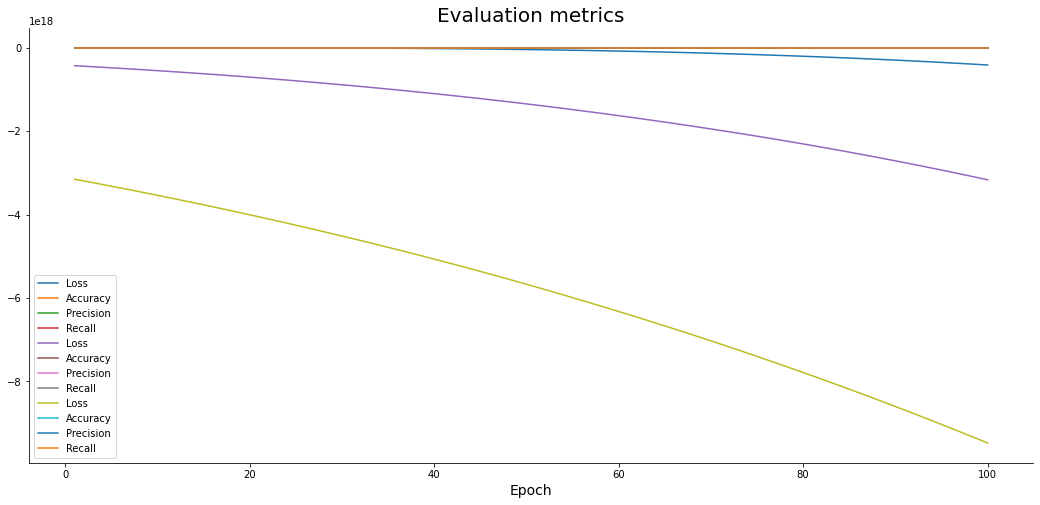

In [43]:
import tensorflow as tf
from matplotlib import rcParams
tf.random.set_seed(42)

model = tf.keras.Sequential([
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

model.compile(
    loss=tf.keras.losses.binary_crossentropy,
    optimizer=tf.keras.optimizers.Adam(lr=0.03),
    metrics=[
        tf.keras.metrics.BinaryAccuracy(name='accuracy'),
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
)

for test_size in splits:
    print("\nSplit: Train:{}% Test:{}%".format(100 - (test_size * 100), test_size * 100))

    # Stratify guarantees that the same proportion of the classes will be available in train and test
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=test_size, stratify=y)
    history = model.fit(x_train, y_train, epochs=100)
    plot_result(history)

In [ ]:
from tensorflow.python.keras.utils.np_utils import to_categorical
from others.eeg import EEGNet

def run_eeg():
    model = EEGNet(nb_classes = 4, Chans = 128, Samples = 512)
    model.compile(loss = 'categorical_crossentropy', optimizer = 'adam')

    Xx = data_array
    Yy = label_array

    x_train, x_test, y_train, y_test = train_test_split(data_array, label_array, test_size=0.20, stratify=y)

    # convert labels to one-hot encodings.
    Y_train = to_categorical(y_train)
    Y_test = to_categorical(y_test)

    X_train = x_train.reshape(x_train.shape[0], 128, 512)
    X_test = x_test.reshape(x_test.shape[0], 128, 512)

    print('X_train shape:', X_train.shape)
    print(X_train.shape[0], 'train samples')
    print('X_test shape:', X_test.shape)
    print(X_test.shape[0], 'test samples')

    print('Y_train shape:', Y_train.shape)
    print(Y_train.shape[0], 'train samples')
    print('Y_test shape:', Y_test.shape)
    print(Y_test.shape[0], 'test samples')

    # configure the EEGNet-8,2,16 model with kernel length of 32 samples (other
    # model configurations may do better, but this is a good starting point)
    model = EEGNet(nb_classes = 4, Chans = 128, Samples = 512)

    # compile the model and set the optimizers
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])

    # count number of parameters in the model
    numParams    = model.count_params()

    fittedModel = model.fit(X_train, Y_train, batch_size = 16, epochs = 300, verbose = 2)

run_eeg()

X_train shape: (1788, 128, 512)
1788 train samples
X_test shape: (448, 128, 512)
448 test samples
Y_train shape: (1788, 4)
1788 train samples
Y_test shape: (448, 4)
448 test samples
Epoch 1/300
112/112 - 1s - loss: nan - accuracy: 0.2517
Epoch 2/300
112/112 - 1s - loss: nan - accuracy: 0.2500
Epoch 3/300
112/112 - 1s - loss: nan - accuracy: 0.2500
Epoch 4/300
112/112 - 1s - loss: nan - accuracy: 0.2500
Epoch 5/300
112/112 - 1s - loss: nan - accuracy: 0.2500
Epoch 6/300
112/112 - 1s - loss: nan - accuracy: 0.2500
Epoch 7/300
112/112 - 1s - loss: nan - accuracy: 0.2500
Epoch 8/300
112/112 - 1s - loss: nan - accuracy: 0.2500
Epoch 9/300
112/112 - 1s - loss: nan - accuracy: 0.2500
Epoch 10/300
112/112 - 1s - loss: nan - accuracy: 0.2500
Epoch 11/300
112/112 - 1s - loss: nan - accuracy: 0.2500
Epoch 12/300
112/112 - 1s - loss: nan - accuracy: 0.2500
Epoch 13/300
112/112 - 1s - loss: nan - accuracy: 0.2500
Epoch 14/300
112/112 - 1s - loss: nan - accuracy: 0.2500
Epoch 15/300
112/112 - 1s - l

[0.2488822652757079, 0.2667660208643815, 0.27123695976154993]


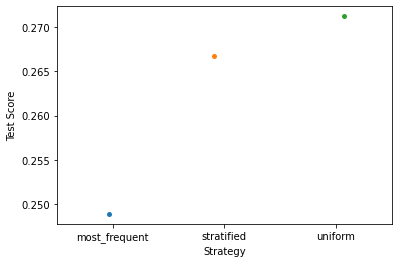

In [26]:
# Implementing Dummy Classifier to have a baseline for our models

from sklearn.dummy import DummyClassifier
import seaborn as sns
import matplotlib.pyplot as plt

strategies = ['most_frequent', 'stratified', 'uniform']

test_scores = []
for s in strategies:
    dclf = DummyClassifier(strategy = s, random_state = random_state)
    dclf.fit(x_train, y_train)
    score = dclf.score(x_test, y_test)
    test_scores.append(score)

print(test_scores)
ax = sns.stripplot(strategies, test_scores);
ax.set(xlabel ='Strategy', ylabel ='Test Score')
plt.show()